<h1><b>Neural Networks Coursework </b> - CIFAR-10 Image Classification Problem</h1>

In [31]:
# Importing  all the necessary dependencies ->

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Task 1 - Reading the Dataset & Creating the DataLoaders

In [32]:
# Defining the hyperparameters here ->

num_epochs = 40
learning_rate = 0.0015
batch_size = 128

# Preparing the dataset ->

#  The Training Set ->
transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# The Test Set -> 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Downloading the dataset, and storing in 'data' directory- (Train Set, Test Set) ->

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_train)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


<b>Visualizing the Samples</b> 

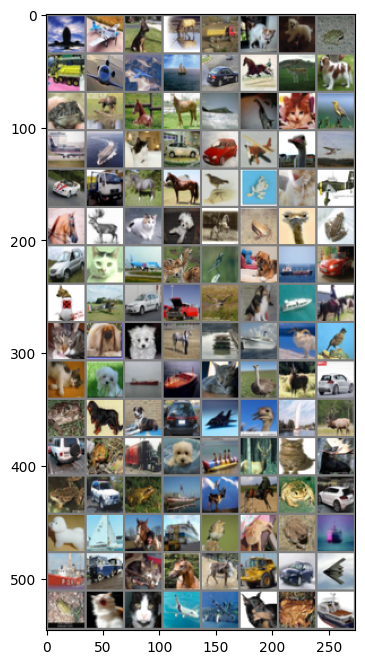

In [33]:
import matplotlib.pyplot as plt
import numpy as np

#  The Functions to show an image ->
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # Unnormalizing
    npimg = img.numpy()
    fig = plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Getting some random training images  ->
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images ->
imshow(torchvision.utils.make_grid(images))

## Task 2 - Creating the Model 

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

# Here Defining a Block class, and representing a building block for the Custom model ->

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, k)
        
        # Convolutional layers for the block ->
        self.convs = nn.ModuleList()
        for _ in range(k):
            conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            # Initializing the weights of the convolutional layer -> 
            nn.init.kaiming_normal_(conv.weight, mode='fan_in', nonlinearity='relu')
            self.convs.append(conv)
            
        # The  Residual connection -> 
        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            # Initializing the weights of the residual connection here -> 
            nn.init.kaiming_normal_(self.residual[0].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        b, c, _, _ = x.size()
        a = self.fc(self.avg_pool(x).view(b, c))
        a = F.softmax(a, dim=1).view(b, -1, 1, 1)

        # Performing the adaptive convolutions with the calculated weights -> 
        out = 0
        for i, conv in enumerate(self.convs):
            out += a[:, i:i + 1] * conv(x)
        
        # Adding the residual connection to the output ->
        res = self.residual(x)
        out += res
        return out

# Custom model Class ->

class Custmodel(nn.Module):
    def __init__(self):
        super(Custmodel, self).__init__()
        
        # Defining the backbone of the model here ->
        self.backbone = nn.Sequential(
            Block(3, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            Block(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Block(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            Block(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Block(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            Block(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Block(256, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            Block(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)

        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Reduce the spatial dimensions to 1x1
            nn.Flatten(),                 # Flatten the tensor into a 1D vector
            nn.Linear(512, 10)            # Fully connected layer to produce the final class scores
        )
        
    # Defining the forward pass of the model ->
    def forward(self, x):
        x = self.backbone(x)         
        x = self.classifier(x)        
        return x
    
model = Custmodel()

## Task 3 - Defining the Loss Function and Optimizer

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

backbone = Custmodel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Adam Optimizer 

# Defining the learning rate scheduler here ->
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

total_steps = len(trainloader)

## Task 4 - Script for Training the Model 

<b>Training and the Validation Functions</b>

In [36]:
def train_epoch(model, dataloader, criterion, optimizer, device, accumulation_steps=4):
    model.train()  # Setting the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    accumulation_steps = 5 
    
    optimizer.zero_grad()  # Reset the gradients outside the loop
  
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)  # Moving images and labels to the device
        outputs = model(images) 
        loss = criterion(outputs, labels)  
        loss.backward() 

        # Updating  the model parameters ->
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()  
            optimizer.zero_grad()  

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class labels
        total += labels.size(0)  # Update the total number of samples
        correct += predicted.eq(labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / len(dataloader)  # Calculate average loss for the epoch
    epoch_acc = correct / total  # Calculate accuracy for the epoch

    return epoch_loss, epoch_acc

def valid_epoch(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disabling the gradient calculation (no_grad)
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data  # Unpack the input data and the labels
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss

            running_loss += loss.item()  # Accumulate the loss

            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class labels
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / (i + 1)  # Calculate the average loss for the epoch
    epoch_acc = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

In [37]:
# Move the model to the device ->
model.to(device)

# Loop through each batch of the data ->
for images, labels in trainloader:
    # Move the data to the device ->
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass, backward pass, and update  the parameters ->
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

<b> Training the Model and Printing all the Results </b>

Epoch [4/40], Training Loss: 0.2548, Training Acc: 0.9109, Validation Loss: 0.5723, Validation Acc: 0.8239
Epoch [8/40], Training Loss: 0.0470, Training Acc: 0.9844, Validation Loss: 0.6561, Validation Acc: 0.8453
Epoch [12/40], Training Loss: 0.0197, Training Acc: 0.9939, Validation Loss: 0.7048, Validation Acc: 0.8585
Epoch [16/40], Training Loss: 0.0155, Training Acc: 0.9949, Validation Loss: 0.7539, Validation Acc: 0.8586
Epoch [20/40], Training Loss: 0.0060, Training Acc: 0.9983, Validation Loss: 0.7245, Validation Acc: 0.8679
Epoch [24/40], Training Loss: 0.0007, Training Acc: 0.9998, Validation Loss: 0.7096, Validation Acc: 0.8732
Epoch [28/40], Training Loss: 0.0001, Training Acc: 1.0000, Validation Loss: 0.7133, Validation Acc: 0.8769
Epoch [32/40], Training Loss: 0.0000, Training Acc: 1.0000, Validation Loss: 0.7244, Validation Acc: 0.8788
Epoch [36/40], Training Loss: 0.0000, Training Acc: 1.0000, Validation Loss: 0.7244, Validation Acc: 0.8796
Epoch [40/40], Training Loss: 

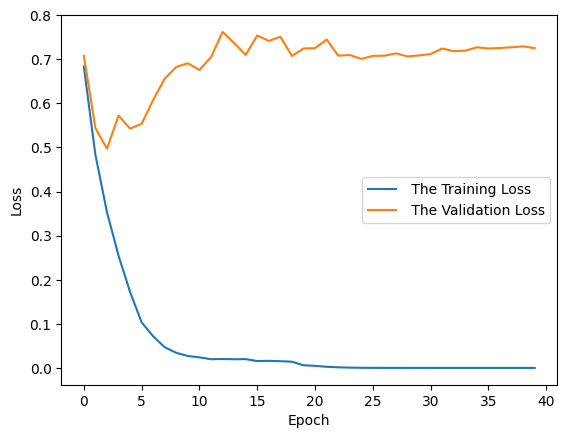

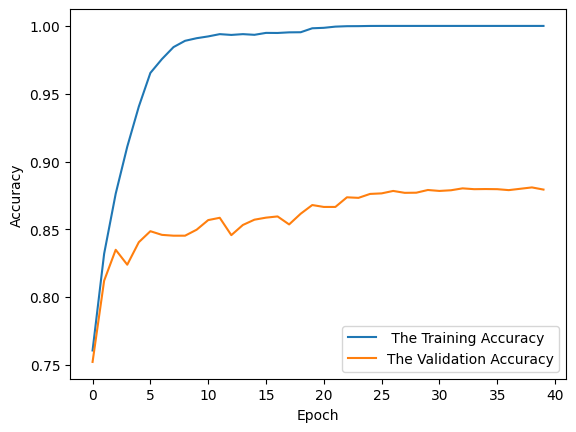

In [38]:
import time
import matplotlib.pyplot as plt

# Training the parameters -> 
num_epochs = 40
print_every = 4 # prints metrics every 4 Epochs 

# Storing the loss and the  accuracy history -> 
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

start_time = time.time()

# Loop through each epoch ->
for epoch in range(num_epochs):
    # Train the model for one epoch and calculate the training loss and  the accuracy ->
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    # Validate the model and calculate validation loss and the accuracy ->
    val_loss, val_acc = valid_epoch(model, testloader, criterion, device)

    # Update the learning rate scheduler at every epoch ->
    scheduler.step()

    # Store the calculated losses and accuracies for the current epoch ->
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # Print the losses and accuracies for the current epoch if it's a multiple of 'print_every' ->
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

end_time = time.time()

print(f'Training finished in {(end_time - start_time):.2f} seconds.')

# Plotting the loss curves ->
plt.figure()
plt.plot(train_loss_history, label=' The Training Loss')
plt.plot(val_loss_history, label=' The Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_history, label=' The Training Accuracy')
plt.plot(val_acc_history, label='The Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
 # Saving the Model -

torch.save(backbone.state_dict(), 'model-1.pt')

## Task 5 - Final Model Accuracy

In [40]:
print('The training accuracy is: ', train_acc*100)
print('The validation accuracy is: ', val_acc*100)



The training accuracy is:  100.0
The validation accuracy is:  87.92999999999999
